# **Auto Encoder**

# **Settings**

In [1]:
import os
# os.chdir('/content/drive/MyDrive/Colab Notebooks/메타버스 아카데미/Data/')
import warnings
warnings.filterwarnings('ignore')                       # warning 출력 false

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import koreanize_matplotlib
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm 

import torch
import torchvision 
import torch.nn.functional as F
from torch import nn, optim
from torchvision import transforms, datasets

## ***! Note Auto Encoder - Unsupervised Learning***
* 인코더, 디코더 개념 등장
    * 인코딩? 원본데이터를 압축, 특징을 추출
    * 디코딩? 원본데이터로 다시 변환
* Latent Variable Z 중요하다.(Buttleneck)
* 정보를 압출하기 때문에 정보의 손실은 필연적
* 이상치 탐지, 노이즈 제거, 컬러 변환 등 다방면에 활용할 수 있는 모델
* 생성모델의 기본

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


# **1. 데이터 불러오기**

In [3]:
from torchvision.transforms import ToTensor

train_data = datasets.FashionMNIST(root='./',train=True, download=True, transform=ToTensor())

In [4]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)

In [5]:
images, labels = next(iter(train_loader))
print(f'images {images.shape}   labels {labels.shape}')

images torch.Size([32, 1, 28, 28])   labels torch.Size([32])


# **2. 모델 설정**

In [6]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(in_features=28*28,out_features=128),
            nn.ReLU(),
            nn.Linear(in_features=128,out_features=64),
            nn.ReLU(),
            nn.Linear(in_features=64,out_features=12),
            nn.ReLU(),
            nn.Linear(in_features=12,out_features=3)
            
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(in_features=3,out_features=12),
            nn.ReLU(),
            nn.Linear(in_features=12,out_features=64),
            nn.ReLU(),
            nn.Linear(in_features=64,out_features=128),
            nn.ReLU(),
            nn.Linear(in_features=128,out_features=28*28),
            nn.Sigmoid()     # 0과 1사이의 값
        )
        
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        
        return encoded, decoded

In [7]:
model = AutoEncoder()
model.to(device)

AutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=12, bias=True)
    (5): ReLU()
    (6): Linear(in_features=12, out_features=3, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=3, out_features=12, bias=True)
    (1): ReLU()
    (2): Linear(in_features=12, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=784, bias=True)
    (7): Sigmoid()
  )
)

# **3. 모델 학습**

In [8]:
from torch.optim import Adam

optimizer = Adam(model.parameters(), lr=1e-4)
criterion = nn.MSELoss()

def train_model(model, train_loader):
    model.train()
    
    for step, (images, labels) in enumerate(train_loader):
        x = images.view(-1,28*28).to(device)
        y = images.view(-1,28*28).to(device)
        labels = labels.to(device)
        
        encoded, decoded = model(x)

        loss = criterion(decoded, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

In [9]:
view_data = train_data.data[:5].view(-1,28*28)
view_data = view_data.type(torch.FloatTensor)/255.

Epoch: 1


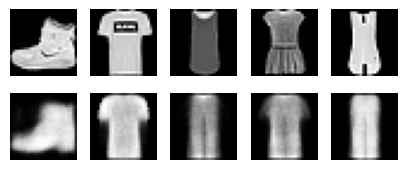

Epoch: 2


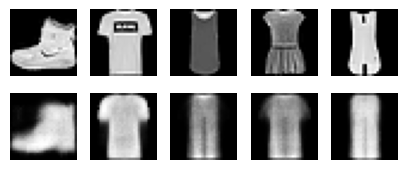

Epoch: 3


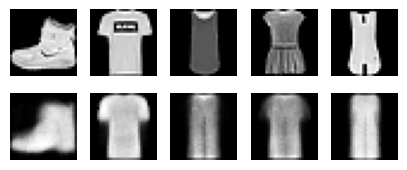

Epoch: 4


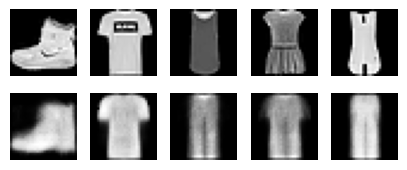

Epoch: 5


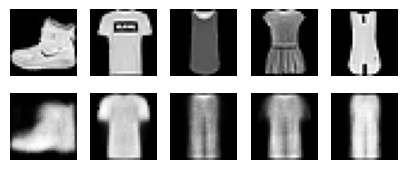

Epoch: 6


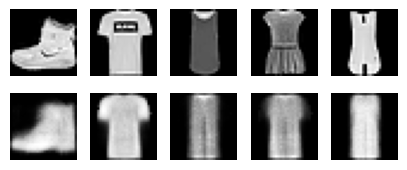

Epoch: 7


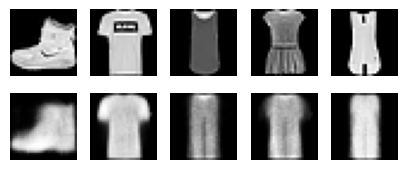

Epoch: 8


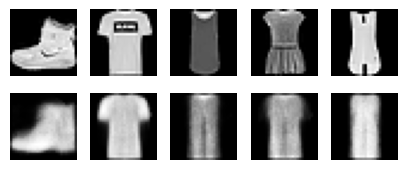

Epoch: 9


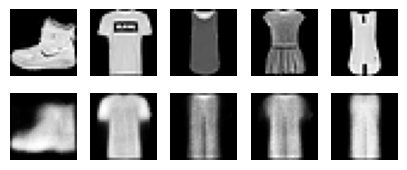

Epoch: 10


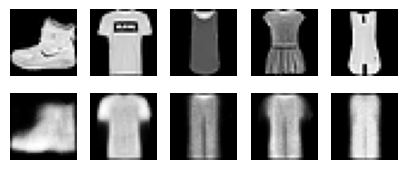

Epoch: 11


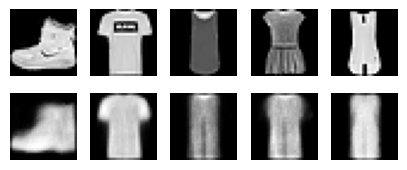

Epoch: 12


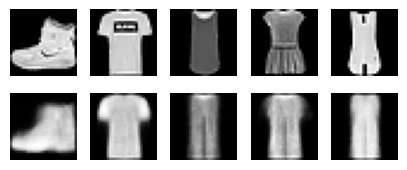

Epoch: 13


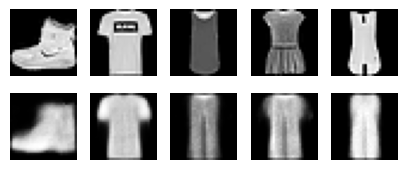

Epoch: 14


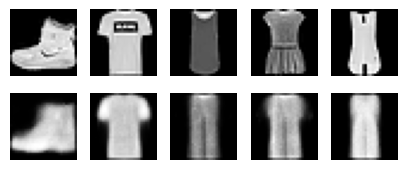

Epoch: 15


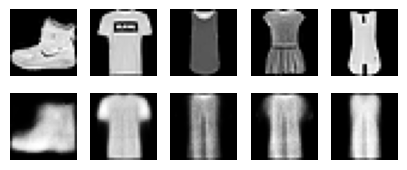

Epoch: 16


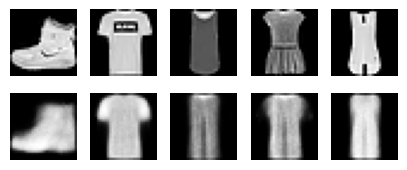

Epoch: 17


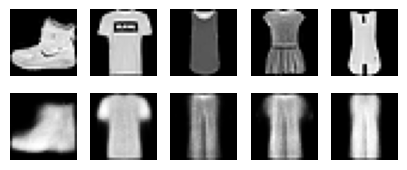

Epoch: 18


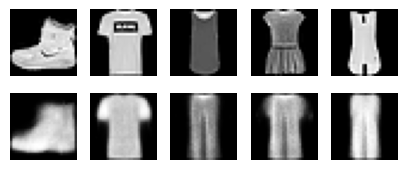

Epoch: 19


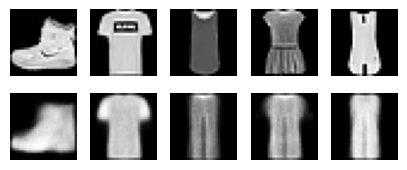

Epoch: 20


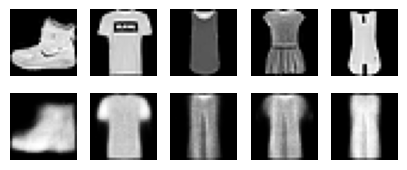

In [11]:
epochs=20
for epoch in range(epochs):
    train_model(model, train_loader)
    
    test_x = view_data.to(device)
    _,decoded_data = model(test_x)
    
    fig = plt.figure(figsize=(5,2))
    print(f'Epoch: {epoch+1}')
    for i in range(5):
        ax = plt.subplot(2,5,i+1)
        img = np.reshape(view_data.data.numpy()[i],(28,28))
        ax.imshow(img, cmap='gray')
        ax.axis('off')
        
    for i in range(5):
        ax = plt.subplot(2,5,5+i+1)
        img = np.reshape(decoded_data.to('cpu').data.numpy()[i],(28,28))
        ax.imshow(img, cmap='gray')
        ax.axis('off')
    plt.show()

# **예측**

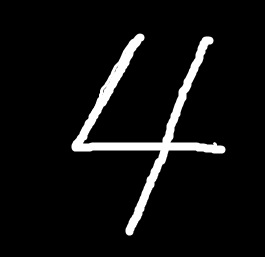

In [14]:
from PIL import Image 
img = Image.open('./label_4.jpg')
img

In [15]:
img = transforms.ToTensor()(img)
img = transforms.Resize(28)(img)
img = transforms.Grayscale()(img)
img.shape

torch.Size([1, 28, 28])

In [16]:
img = img.unsqueeze(0)
img.size()

torch.Size([1, 1, 28, 28])

In [17]:
img = img.view(-1,28*28).to(device)
img.size()

torch.Size([1, 784])

In [18]:
_,pred = model(img)
img = np.reshape(pred.to('cpu').data.numpy()[0],(28,28))
img.shape

(28, 28)

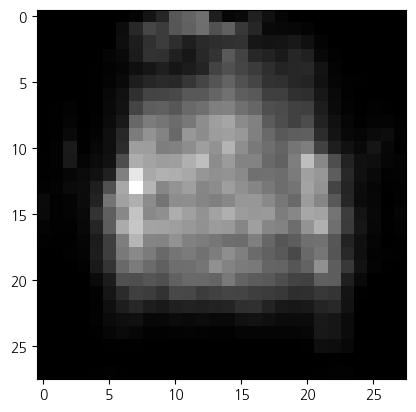

In [19]:
plt.imshow(img,cmap='gray')

# **3차원 그래프 시각화**

In [70]:
view_data = train_data.data[:200].view(-1, 28*28)
view_data = view_data.type(torch.FloatTensor)/255.

test_x = view_data.to(device)

encoded_data, _ = model(test_x)
encoded_data = encoded_data.to('cpu')

In [65]:
test_x.size()

torch.Size([200, 784])

In [71]:
encoded_data.size()

torch.Size([200, 3])

In [67]:
encoded_data[0]

tensor([-54.0562,   5.9450,  -4.7732], grad_fn=<SelectBackward>)

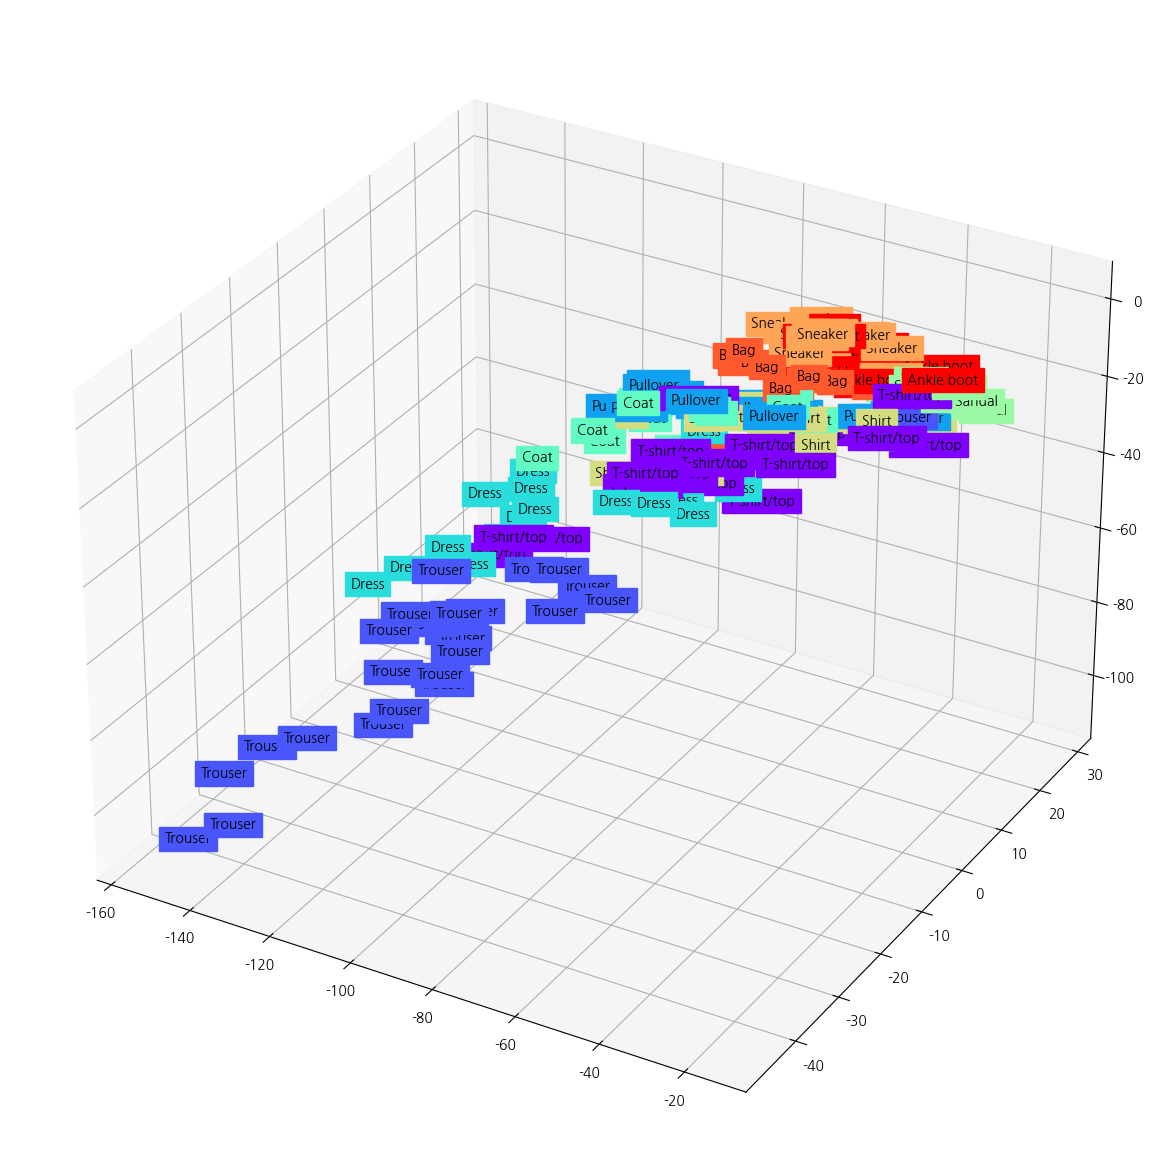

In [85]:
from mpl_toolkits.mplot3d import axes3d

CLASSES = {i:x for i,x in enumerate(train_data.classes)}

X = encoded_data.data[:,0].numpy()
Y = encoded_data.data[:,1].numpy()
Z = encoded_data.data[:,2].numpy()

labels = train_data.targets[:200].numpy()

fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(projection='3d')

for x,y,z,s in zip(X,Y,Z,labels):
    name = CLASSES[s]
    color = cm.rainbow(int(255*s/9))
    ax.text(x,y,z,name,backgroundcolor=color)
    
plot_data = ax.scatter(X,Y,Z,color='red')
ax.set_xlim(X.min(),X.max())
# ax.set_xlim(Y.min(),Y.max())
# ax.set_xlim(Z.min(),Z.max())

plt.show()

# **잠재변수 공간에서 디코딩하기**

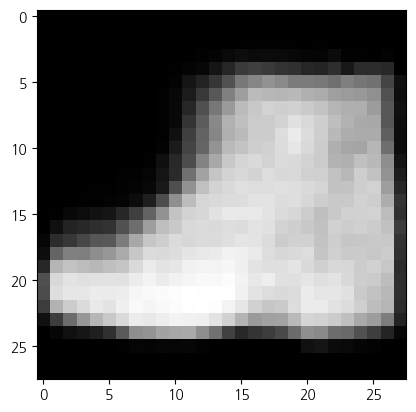

In [53]:
# Z에서 디코딩해서 복원하기
mytest = model.decoder(encoded_data[0].to(device))
img = mytest.to('cpu').data.numpy()
img = np.reshape(img, (28,28))
plt.imshow(img, cmap='gray')

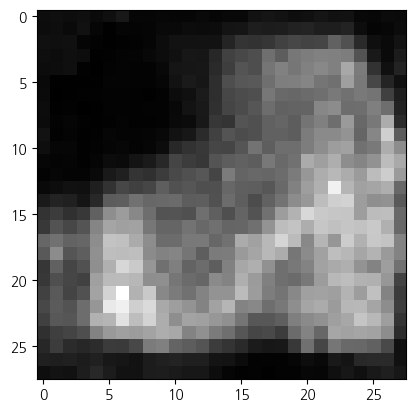

In [56]:
# Z에서 디코딩해서 복원하기
mytest = model.decoder(torch.tensor([1. , 1. , 1.]).to(device))
img = mytest.to('cpu').data.numpy()
img = np.reshape(img, (28,28))
plt.imshow(img, cmap='gray')